# Denoising Diffusion Models

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/cgarciae/simple-ddpm/blob/master/notebooks/ddpm_2d.ipynb)


<details><summary>Setup</summary>

In [ ]:
# Uncomment these line the first time you run the notebook
# ! pip install flax einop
# ! pip install --no-deps clu

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.datasets import make_blobs, make_moons
from sklearn.preprocessing import MinMaxScaler

dataset: str = "moons"
batch_size: int = 128
total_samples: int = 5_000_000
epochs: int = 10
steps_per_epoch = total_samples // (epochs * batch_size)
total_steps = total_samples // batch_size


def get_data():
    if dataset == "moons":
        X, y = make_moons(n_samples=1000, noise=0.1, random_state=0)
    elif dataset == "blobs":
        X = make_blobs(n_samples=1000, centers=6, cluster_std=0.5, random_state=6)[0]
    else:
        raise ValueError(f"Unknown dataset: {dataset}")

    X = MinMaxScaler((-1, 1)).fit_transform(X)
    ds = tf.data.Dataset.from_tensor_slices(X.astype(np.float32))
    ds = ds.repeat()
    ds = ds.shuffle(seed=42, buffer_size=1_000)
    ds = ds.batch(batch_size, drop_remainder=True)
    ds = ds.prefetch(tf.data.AUTOTUNE)

    return X, ds

2022-10-19 16:26:43.406009: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


</details>

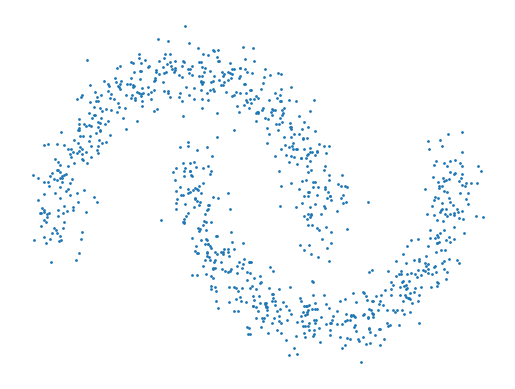

In [2]:
X, ds = get_data()

plt.figure()
plt.scatter(X[:, 0], X[:, 1], s=1)
plt.axis("off")
plt.show()

## Forward Process
![forward](images/forward.png)

In [3]:
import jax
import jax.numpy as jnp
from flax.struct import PyTreeNode

class GaussianDiffusion(PyTreeNode):
    betas: jnp.ndarray
    alphas: jnp.ndarray
    alpha_bars: jnp.ndarray

    @classmethod
    def create(cls, betas: jnp.ndarray) -> "GaussianDiffusion":
        return cls(
            betas=betas,
            alphas=1.0 - betas,
            alpha_bars=jnp.cumprod(1.0 - betas),
        )

@jax.jit
def forward_diffusion(process: GaussianDiffusion, key, x0, t):
    alpha_bars = expand_to(process.alpha_bars[t], x0)
    noise = jax.random.normal(key, x0.shape)
    xt = jnp.sqrt(alpha_bars) * x0 + jnp.sqrt(1.0 - alpha_bars) * noise
    return xt, noise

def expand_to(a, b):
    new_shape = a.shape + (1,) * (b.ndim - a.ndim)
    return a.reshape(new_shape)

## Variance Schedule
<details><summary>Schedules Definition</summary>

In [4]:
# schedules
def polynomial_schedule(beta_start, beta_end, timesteps, exponent=2.0, **kwargs):
    betas = jnp.linspace(0, 1, timesteps) ** exponent
    return betas * (beta_end - beta_start) + beta_start


def sigmoid_schedule(beta_start, beta_end, timesteps, **kwargs):
    betas = jax.nn.sigmoid(jnp.linspace(-6, 6, timesteps))
    return betas * (beta_end - beta_start) + beta_start


def cosine_schedule(beta_start, beta_end, timesteps, s=0.008, **kwargs):
    x = jnp.linspace(0, timesteps, timesteps + 1)
    ft = jnp.cos(((x / timesteps) + s) / (1 + s) * jnp.pi * 0.5) ** 2
    alphas_cumprod = ft / ft[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    betas = jnp.clip(betas, 0.0001, 0.9999)
    betas = (betas - betas.min()) / (betas.max() - betas.min())
    return betas * (beta_end - beta_start) + beta_start


# TODO: create a plot for each schedule
def plot_schedules(beta_start, beta_end, timesteps):
    schedules = [polynomial_schedule, sigmoid_schedule, cosine_schedule]
    _, axs = plt.subplots(1, 3, figsize=(12, 4))
    for i in range(3):
        schedule = schedules[i]
        betas = schedule(beta_start, beta_end, timesteps)
        axs[i].plot(betas)
        axs[i].set_title(schedule.__name__)
        linear = polynomial_schedule(
            betas.min(), betas.max(), timesteps, exponent=1.0
        )
        axs[i].plot(linear, label="linear", color="black", linestyle="dotted")

    plt.show()

def plot_final_schedule(process, schedule, betas):
    timesteps = len(betas)
    n_rows = 2
    n_cols = 7

    plt.figure(figsize=(n_cols * 3, n_rows * 3))
    for i, ti in enumerate(jnp.linspace(0, timesteps, n_cols).astype(int)):
        t = jnp.full((X.shape[0],), ti)
        xt, noise = forward_diffusion(process, jax.random.PRNGKey(ti), X, t)
        plt.subplot(n_rows, n_cols, i + 1)
        plt.scatter(xt[:, 0], xt[:, 1], s=1)
        plt.axis("off")

    plt.subplot(2, 1, 2)
    linear = polynomial_schedule(
        betas.min(), betas.max(), timesteps, exponent=1.0
    )
    plt.plot(linear, label="linear", color="black", linestyle="dotted")
    plt.plot(betas)
    for s in ["top", "bottom", "left", "right"]:
        plt.gca().spines[s].set_visible(False)

    plt.show()

</details>

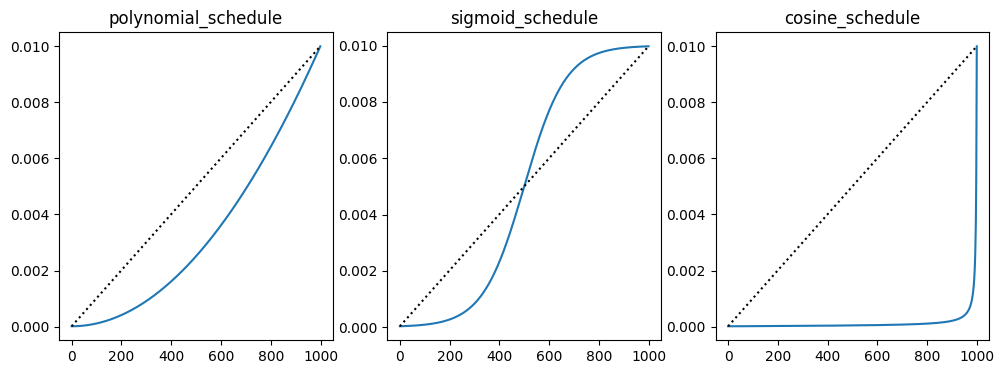

In [5]:
# diffusion
diffusion_schedule: str = "cosine"
diffusion_beta_start: float = 1e-5
diffusion_beta_end: float = 0.01
diffusion_timesteps: int = 1_000

plot_schedules(diffusion_beta_start, diffusion_beta_end, diffusion_timesteps)

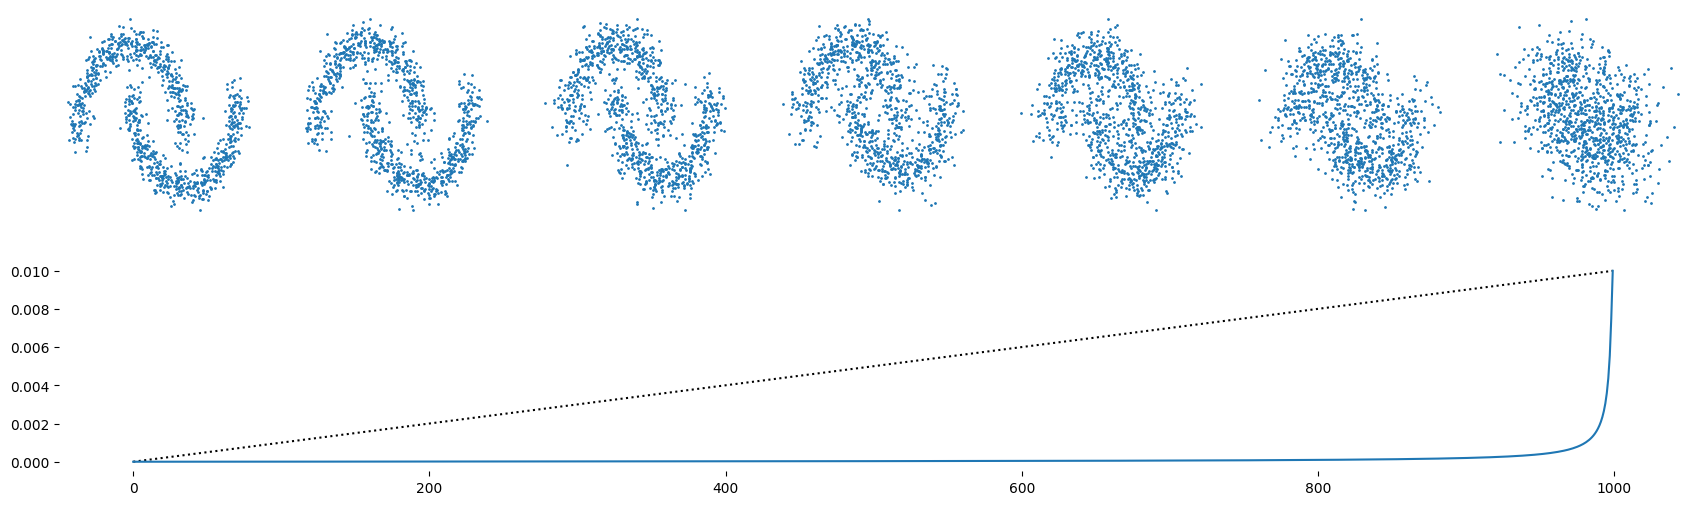

In [6]:


if diffusion_schedule == "polynomial":
    schedule = polynomial_schedule
elif diffusion_schedule == "sigmoid":
    schedule = sigmoid_schedule
elif diffusion_schedule == "cosine":
    schedule = cosine_schedule
else:
    raise ValueError(f"Unknown schedule {diffusion_schedule}")

betas = schedule(diffusion_beta_start, diffusion_beta_end, diffusion_timesteps)
process = GaussianDiffusion.create(betas)

plot_final_schedule(process, schedule, betas)

## Model Definition
<details><summary>Model Architecture</summary>

In [8]:

from flax import struct
import flax.linen as nn

class SinusoidalPosEmb(nn.Module):
    dim: int

    def __call__(self, t):
        half_dim = self.dim // 2
        mul = jnp.log(10000) / (half_dim - 1)
        emb = jnp.exp(-mul * jnp.arange(half_dim))
        emb = t[:, None] * emb[None, :]
        emb = jnp.concatenate([jnp.sin(emb), jnp.cos(emb)], axis=-1)
        return emb


class TimeConditionedDense(nn.Module):
    units: int
    emb_dim: int

    @nn.compact
    def __call__(self, *, x, t):
        t_embeddings = SinusoidalPosEmb(self.emb_dim)(t)
        x = jnp.concatenate([x, t_embeddings], axis=-1)
        x = nn.Dense(self.units)(x)
        return x


class Denoiser(nn.Module):
    units: int = 128
    emb_dim: int = 32

    @nn.compact
    def __call__(self, *, x, t):
        inputs_units = x.shape[-1]
        dense = lambda units: TimeConditionedDense(units, self.emb_dim)
        x = nn.relu(dense(self.units)(x=x, t=t))
        x = nn.relu(dense(self.units)(x=x, t=t)) + x
        x = nn.relu(dense(self.units)(x=x, t=t)) + x
        x = dense(inputs_units)(x=x, t=t)
        return x

</details>

In [9]:
model_units: int = 128
model_emb_dim: int = 32

module = Denoiser(units=model_units, emb_dim=model_emb_dim)

print(module.tabulate(
    jax.random.PRNGKey(42), x=X[:1], t=jnp.array([0]), 
    depth=1, console_kwargs=dict(width=500, no_color=True, force_terminal=False)))


                                             Denoiser Summary                                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ path                   ┃ module               ┃ inputs            ┃ outputs        ┃ params            ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│                        │ Denoiser             │ t: int32[1]       │ float32[1,2]   │                   │
│                        │                      │ x: float32[1,2]   │                │                   │
├────────────────────────┼──────────────────────┼───────────────────┼────────────────┼───────────────────┤
│ TimeConditionedDense_0 │ TimeConditionedDense │ t: int32[1]       │ float32[1,128] │ 4,480 (17.9 KB)   │
│                        │                      │ x: float32[1,2]   │                │                   │
├────────────────────────┼──────────

# Training State
<details><summary>Define TrainState and Metrics</summary>

In [ ]:
from clu.metrics import Average, Collection
from flax.training import train_state

@struct.dataclass
class Metrics(Collection):
    loss: Average.from_output("loss")

    def update(self, **kwargs) -> "Metrics":
        updates = self.single_from_model_output(**kwargs)
        return self.merge(updates)

class TrainState(train_state.TrainState):
    metrics: Metrics

</details>

In [ ]:
import optax

lr_start: float = 1e-3
drop_1_mult: float = 0.1
drop_2_mult: float = 0.1

lr_schedule = optax.piecewise_constant_schedule(
    lr_start,
    {
        int(total_steps * 1 / 3): drop_1_mult,
        int(total_steps * 2 / 3): drop_2_mult,
    },
)

variables = module.init(jax.random.PRNGKey(42), x=X[:1], t=jnp.array([0]))
state: TrainState = TrainState.create(
    apply_fn=module.apply, 
    params=variables["params"], 
    tx=optax.chain(
        optax.clip_by_global_norm(1.0),
        optax.adamw(lr_schedule),
    ),
    metrics=Metrics.empty(),
)

## Sampling Procedure
![ddpm-sampling](images/ddpm-sampling.png)

In [ ]:
from functools import partial
from einop import einop


@jax.jit
def reverse_diffusion(process: GaussianDiffusion, key, x, noise_hat, t):
    betas = expand_to(process.betas[t], x)
    alphas = expand_to(process.alphas[t], x)
    alpha_bars = expand_to(process.alpha_bars[t], x)

    z = jnp.where(
        expand_to(t, x) > 0, jax.random.normal(key, x.shape), jnp.zeros_like(x)
    )
    noise_scaled = betas / jnp.sqrt(1.0 - alpha_bars) * noise_hat
    x = (x - noise_scaled) / jnp.sqrt(alphas) + jnp.sqrt(betas) * z
    return x

@partial(jax.jit, static_argnames=["return_all"])
def sample(key, x0, ts, params, process):
    print("compiling 'sample' ...")
    keys = jax.random.split(key, len(ts))
    ts = einop(ts, "t -> t b", b=x0.shape[0])

    def scan_fn(x, inputs):
        t, key = inputs
        noise_hat = module.apply({"params": params}, x=x, t=t)
        x = reverse_diffusion(process, key, x, noise_hat, t)
        return x, x

    x, xs = jax.lax.scan(scan_fn, x0, (ts, keys))
    return xs

## Training

In [ ]:
loss_type: str = "mae"

if loss_type == "mse":
    loss_metric = lambda a, b: jnp.mean((a - b) ** 2)
elif loss_type == "mae":
    loss_metric = lambda a, b: jnp.mean(jnp.abs(a - b))
else:
    raise ValueError(f"Unknown loss type {loss_type}")



def loss_fn(params, x, t, noise):
    noise_hat = state.apply_fn({"params": params}, x=x, t=t)
    return loss_metric(noise, noise_hat)


@jax.jit
def train_step(key, x, state: TrainState, process: GaussianDiffusion):
    print("compiling 'train_step' ...")
    key_t, key_diffusion, key = jax.random.split(key, 3)
    t = jax.random.uniform(
        key_t, (x.shape[0],), minval=0, maxval=diffusion_timesteps - 1
    ).astype(jnp.int32)
    xt, noise = forward_diffusion(process, key_diffusion, x, t)
    loss, grads = jax.value_and_grad(loss_fn)(state.params, xt, t, noise)
    metrics = state.metrics.update(loss=loss)
    state = state.apply_gradients(grads=grads, metrics=metrics)
    logs = metrics.compute()
    return logs, key, state

#### Training loop

<details><summary>viz_progress</summary>


In [ ]:

def viz_progress(state, process):
    n_cols = 7
    n_samples = 1000
    viz_key = jax.random.PRNGKey(1)
    x = jax.random.normal(viz_key, (n_samples, *X.shape[1:]))

    ts = np.arange(diffusion_timesteps)[::-1]
    xs = np.asarray(sample(viz_key, x, ts, state.params, process))
    _, axs_diffusion = plt.subplots(1, n_cols, figsize=(n_cols * 3, 3))

    ts = jnp.linspace(0, diffusion_timesteps - 1, n_cols).astype(int)
    for i, ti in enumerate(ts):
        axs_diffusion[i].clear()
        axs_diffusion[i].scatter(xs[ti, :, 0], xs[ti, :, 1], s=1)
        axs_diffusion[i].axis("off")
    plt.show()

</details>

In [ ]:
import numpy as np
from tqdm import tqdm

eval_every: int = 2000
log_every: int = 200

key = jax.random.PRNGKey(42)
ds_iterator = ds.as_numpy_iterator()

step = 0
history = []

In [ ]:
for step in tqdm(range(step, total_steps), total=total_steps, unit="step"):
    x = ds_iterator.next()
    logs = {}

    if step % steps_per_epoch == 0:
        viz_progress(state, process)

    # --------------------
    # trainig step
    # --------------------
    logs, key, state = train_step(key, x, state, process)
    logs["step"] = step
    
    if step % log_every == 0 and logs:
        history.append(logs)
        state = state.replace(metrics=state.metrics.empty())

#### Visualize Loss

In [ ]:
# plot history
plt.figure(figsize=(10, 6))
steps = np.array([h["step"] for h in history])
plt.plot(steps, [h["loss"] for h in history], label="loss")
plt.legend()
plt.show()

## Analysis

#### Compare samples with real data

In [ ]:
n_samples = 1000
viz_key = jax.random.PRNGKey(1)
x = jax.random.normal(viz_key, (n_samples, *X.shape[1:]))
ts = np.arange(diffusion_timesteps)[::-1]
x = np.asarray(sample(viz_key, x, ts, state.params, process))[-1]

# plot x and X side by side
_, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].scatter(x[:, 0], x[:, 1], s=1)
axs[0].axis("off")
axs[0].set_title("model")
axs[1].scatter(X[:, 0], X[:, 1], s=1)
axs[1].axis("off")
axs[1].set_title("data")
plt.show()

#### Visualize diffusion process

<details><summary>plot_trajectory_2d</summary>

In [ ]:
from base64 import b64encode
from pathlib import Path
from tempfile import TemporaryDirectory

from einop import einop
from IPython.display import HTML, display
from matplotlib import animation
from IPython import get_ipython


def plot_trajectory_2d(
    fig,
    xs: np.ndarray,
    interval: int = 10,
    repeat_delay: int = 1000,
    step_size: int = 1,
    end_pad: int = 500,
):
    xs = np.concatenate([xs[::step_size], xs[-1:]], axis=0)
    # replace last sample to create a 'pause' effect
    pad_end = einop(xs[-1], "... -> batch ...", batch=end_pad)
    xs = np.concatenate([xs, pad_end], axis=0)
    N = len(xs)
    scatter = plt.scatter(xs[0][:, 0], xs[0][:, 1], s=1)

    def animate(i):
        scatter.set_offsets(xs[i])
        return [scatter]

    anim = animation.FuncAnimation(
        fig,
        animate,
        init_func=lambda: animate(0),
        frames=np.linspace(0, N - 1, N, dtype=int),
        interval=interval,
        repeat_delay=repeat_delay,
        blit=True
    )

    with TemporaryDirectory() as tmpdir:
        img_name = Path(tmpdir) / f"diffusion.gif"
        anim.save(str(img_name), writer="pillow", fps=60)
        image_bytes = b64encode(img_name.read_bytes()).decode("utf-8")

    display(HTML(f"""<img src='data:image/gif;base64,{image_bytes}'>"""))
    plt.close()

</details>

In [ ]:
x = jax.random.uniform(key, (1000, 2), minval=-1, maxval=1)
ts = jnp.arange(diffusion_timesteps, 0, -1)
xs = sample(key, x, ts, state.params, process)

fig = plt.figure(figsize=(8, 8))
plt.axis("off")
plot_trajectory_2d(fig, xs, step_size=4)

##### Visualize gradient field

<details><summary>plot_gradients</summary>

In [ ]:
def plot_gradient_field(x, grad, alpha=0.9, data=None):
    grad_norm = np.linalg.norm(grad, axis=-1, ord=2, keepdims=True)
    grad_log1p = grad / (grad_norm + 1e-9) * np.log1p(grad_norm)
    # Perform the plots
    
    if data is not None:
        plt.scatter(data[:, 0], data[:, 1], alpha=0.8, s=40)
    
    quiver = plt.quiver(*x.T, *grad_log1p.T, width=0.002, alpha=alpha)

</details>

In [ ]:
# create a meshgrid between -1 and 1
xx, yy = np.meshgrid(np.linspace(-1.2, 1.2, 40), np.linspace(-1.2, 1.2, 40))
x = np.stack([xx, yy], axis=-1).reshape(-1, 2)

# get predicted noise predictions, gradient is negative noise
t = np.array(0, dtype=jnp.int32)
t = einop(t, "-> batch", batch=len(x))
grad = -state.apply_fn({"params": state.params}, x=x, t=t)

# create quiver plot from p_grad
plt.figure(figsize=(8, 8))
plt.axis("off")
plot_gradient_field(x, grad, data=X)


#### Visualize density function

<details><summary>plot_density</summary>

In [ ]:
def plot_density(state, ts):
    xx, yy = np.meshgrid(np.linspace(-1.2, 1.2, 40), np.linspace(-1.2, 1.2, 40))
    X = jnp.stack([xx, yy], axis=-1)

    def mass_fn(x, t):
        t_ = jnp.full((1,), t)
        x_ = x[None]
        noise_hat = state.apply_fn({'params': state.params}, x=x_, t=t_)
        magnitud = jnp.linalg.norm(noise_hat, axis=-1, keepdims=False)
        mass = jnp.exp(-magnitud)
        return mass[0]

    mass_fn = jax.jit(
        jax.vmap(
            jax.vmap(jax.vmap(mass_fn, in_axes=(0, None)), in_axes=(0, None)),
            in_axes=(None, 0),
            out_axes=-1,
        )
    )
    mass = mass_fn(X, ts).mean(axis=-1)
    plt.contourf(xx, yy, mass, levels=100, cmap="Blues")

</details>

In [ ]:
# create a contour plot using the magnitude of the gradient
plt.figure(figsize=(8, 8))
plt.axis("off")

ts = np.array([0, 1, 10], dtype=np.int32)
plot_density(state, ts)
plt.scatter(X[:, 0], X[:, 1], alpha=0.5, c='black', s=5)